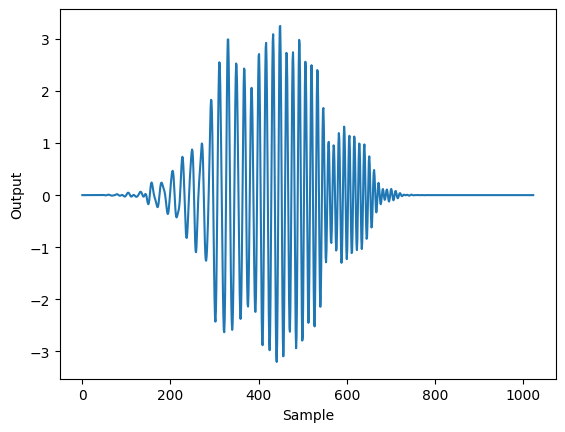

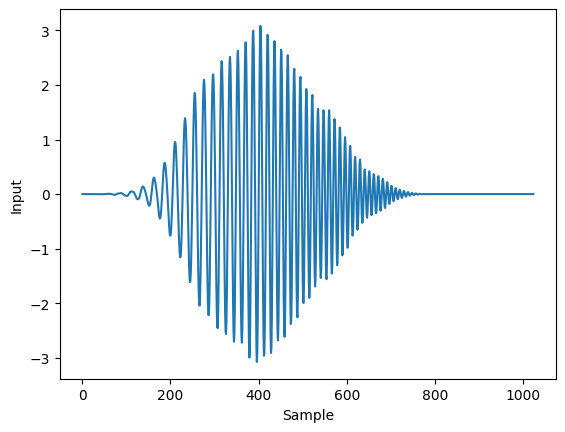

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load dataset
data = np.genfromtxt("data/flutter.dat")
u = data[:,0]
y = data[:,1]

# Plot input and output
if True:
    t_ = np.linspace(0, len(y)-1, len(y))
    plt.figure()
    plt.plot(t_, y)
    plt.xlabel("Sample")
    plt.ylabel("Output")

    plt.figure()
    plt.plot(t_, u)
    plt.xlabel("Sample")
    plt.ylabel("Input")
    plt.show()

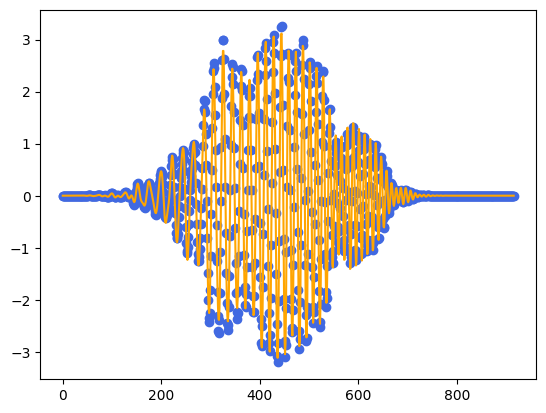

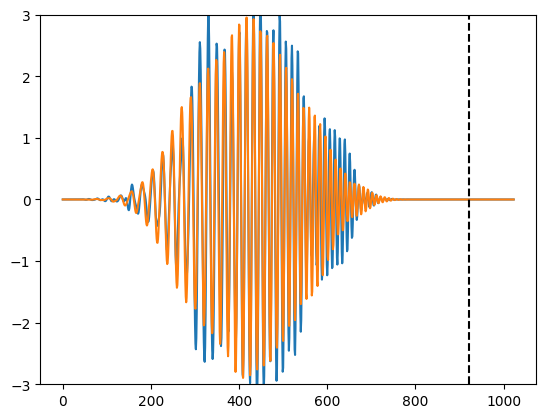

In [59]:
# Construct X and Y matrices for regression
TRAIN_TEST_SPLIT = 0.9
NUM_DELAYS = 5
LS_ORDER = 2
BETA = 1e1

# Split raw data into train and test sets
train_test_index = int(len(y)*TRAIN_TEST_SPLIT)
y_train = y[:train_test_index]
y_test  = y[train_test_index:]
u_train = u[:train_test_index]
u_test  = u[train_test_index:]

# Construct training data matrices
Y_train = np.expand_dims(y_train[NUM_DELAYS:], axis=1)
X_train = np.zeros(shape=(len(y_train)-NUM_DELAYS, 2*NUM_DELAYS))
for i in range(len(y_train)-NUM_DELAYS):
    X_train[i,:NUM_DELAYS] = y_train[i:i+NUM_DELAYS]
    X_train[i,NUM_DELAYS:] = u_train[i:i+NUM_DELAYS]

def construct_H(X, model_order):
    dp, features = X.shape
    H = np.ones(shape=(dp,1))
    for order in range(1,model_order+1):
        for i in range(features):
            for j in range(i, features):
                if j == i:
                    H_ = np.power(X[:,[i]], order)
                    H = np.hstack((H, H_))
                else:
                    for k in range(1, order):
                        H_ = np.multiply(np.power(X[:,[i]], k), np.power(X[:,[j]], order-k))
                        H = np.hstack((H, H_))
    return H

def model_ls(x, w, model_order):
    h_ = construct_H(x, model_order)
    y_ = h_ @ w
    return y_

# Get model params
H_train = construct_H(X_train, LS_ORDER)
w = np.linalg.inv(H_train.T @ H_train + BETA*np.eye(H_train.shape[1])) @ H_train.T @ Y_train

# Plot training results
t_ = np.linspace(0, Y_train.shape[0]-1, Y_train.shape[0])
Y_pred_train = model_ls(X_train, w, model_order=LS_ORDER)
plt.figure()
plt.scatter(t_, Y_train, c="royalblue")
plt.plot(t_, Y_pred_train, c="orange")

# Testing loop
Y_pred = np.zeros(shape=(0,1))
for i in range(len(y)):
    if i < NUM_DELAYS:
        Y_pred = np.vstack((Y_pred, y[i]))
    else:
        X_ = np.hstack(([Y_pred[-NUM_DELAYS:,0]], [u[i-NUM_DELAYS:i]]))
        Y_pred_ = model_ls(X_, w, model_order=LS_ORDER)
        Y_pred = np.vstack((Y_pred, Y_pred_))
Y_pred = Y_pred.flatten()

plt.figure()
plt.plot(y)
plt.plot(Y_pred)
plt.axvline(x=train_test_index, c="black", ls="--")
plt.ylim([-3,3])
plt.show()